In this notebook we compare the statistical properties for the following bar sampling techniques:

- Time bars
- Volume bars
- Dollar bars

We look into the following statistical properties:

- Normality of (log) returns.
- Serial correlation.

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import mlfinlab as ml
import datetime
import scipy
from alpha_vantage.timeseries import TimeSeries
%matplotlib inline

In [2]:
#set credentials for stock API
ts = TimeSeries(key = 'PTME3FLJAHB9CY', output_format = 'pandas')

In [34]:
#define global variables
DATE = "date"
PRICE = "4. close"
VOLUME = "5. volume"

In [4]:
#load  daily sample data
df, df_meta = ts.get_daily_adjusted(symbol = 'MSFT', outputsize = 'full')

In [27]:
#load minutely sample data
df, df_meta = ts.get_intraday(symbol = "MSFT", interval = "1min", outputsize = "full")

In [31]:
df

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2020-01-24 16:00:00,164.8900,165.0600,164.870,165.0400,511882.0
2020-01-24 15:59:00,164.9800,165.0000,164.860,164.8900,385888.0
2020-01-24 15:58:00,165.1100,165.1700,164.960,164.9600,259380.0
2020-01-24 15:57:00,165.1150,165.1800,165.095,165.1050,102700.0
2020-01-24 15:56:00,165.1801,165.2300,165.080,165.1100,168237.0
...,...,...,...,...,...
2020-01-17 09:35:00,166.6800,166.6800,166.680,166.6800,142245.0
2020-01-17 09:34:00,166.8500,166.9000,166.550,166.5877,172559.0
2020-01-17 09:33:00,166.9000,166.9475,166.720,166.8400,145436.0


In [28]:
def get_sample_df(df, date_col, price_col, vol_col):
    df = df.reset_index()[[date_col, price_col, vol_col]]
    return df

In [194]:
def returns(df, price_col, log = False):
    if log:
        df[price_col] = np.log(df[price_col])
    
    df["return"] = df[price_col].diff(-1)
    return df

In [184]:
sample_df = get_sample_df(df, DATE, PRICE, VOLUME)

In [185]:
vol_bars = ml.data_structures.get_volume_bars(sample_df, 200000)
vol_bars.shape

Reading data in batches:
Batch number: 0
Returning bars 



(367, 10)

In [186]:
dollar_bars = ml.data_structures.get_dollar_bars(sample_df, threshold = 20000000)
dollar_bars.shape

Reading data in batches:
Batch number: 0
Returning bars 



(558, 10)

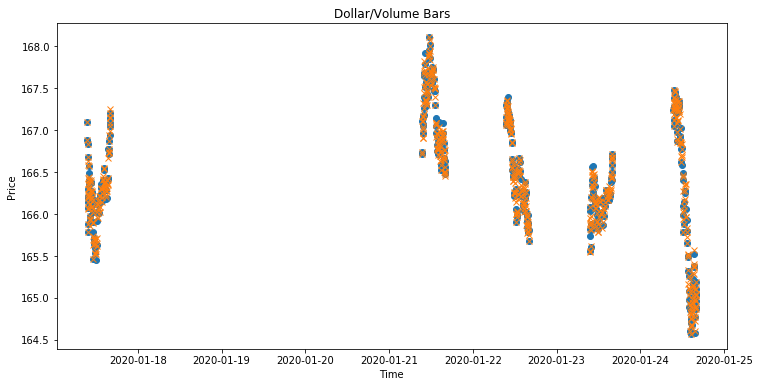

In [187]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(vol_bars["date_time"], vol_bars["close"], "o")
ax.plot(dollar_bars["date_time"], dollar_bars["close"], "x")
ax.set_title("Dollar/Volume Bars")
ax.set_xlabel("Time")
ax.set_ylabel("Price")
plt.show()

When plotting dollar/volume bars we see how bars are sampled more frequently at high traffic times. Let's zoom in on one day to see the pattern more clearly. 

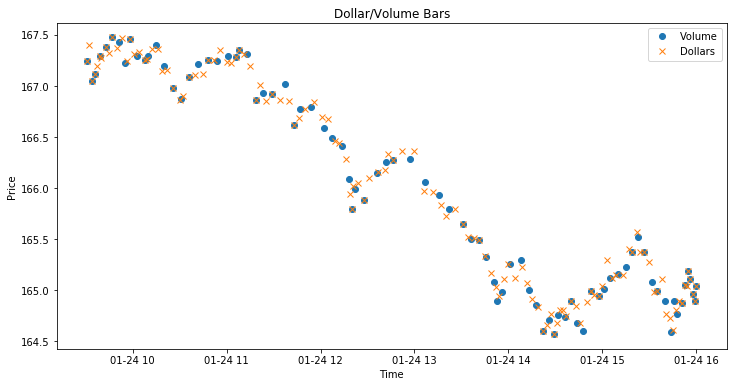

In [188]:
temp_dollar_bars = dollar_bars[dollar_bars["date_time"].dt.date == datetime.date(2020, 1, 24)]
temp_vol_bars = vol_bars[vol_bars["date_time"].dt.date == datetime.date(2020, 1, 24)]
hours = mdates.HourLocator(interval = 1)

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(temp_vol_bars["date_time"], temp_vol_bars["close"], "o", label = "Volume")
ax.plot(temp_dollar_bars["date_time"], temp_dollar_bars["close"], "x", label = "Dollars")
ax.set_title("Dollar/Volume Bars")
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.xaxis.set_major_locator(hours)
plt.legend()
plt.show()

When looking at one day we can more clearly see how more bars are sampled at opening/closing hours of the stock market.

# Normality of Returns
We can start by visually inspecting the distribution of the returns for different sampling techniques to get a better understanding of their distributions.

In [197]:
dollar_bars = returns(dollar_bars, "close", log = "True")
vol_bars = returns(vol_bars, "close", log = "True")
sample_df = returns(sample_df, PRICE, log = "True")

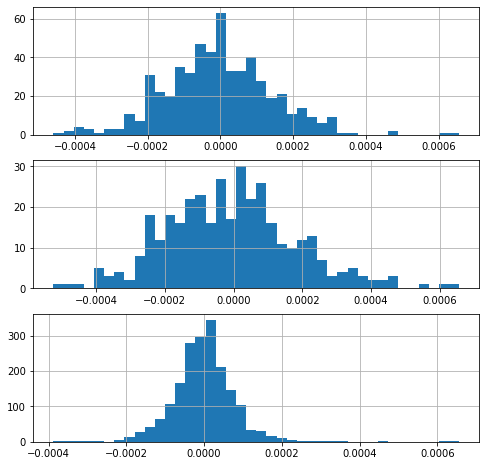

In [202]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 8))
dollar_bars["return"].hist(ax = axes[0], bins = 40, label = "Dollar bars")
vol_bars["return"].hist(ax = axes[1], bins = 40, label = "Volume bars")
sample_df["return"].hist(ax = axes[2], bins = 40, label = "Time bars")
plt.show()

We can more formallly look into the normality of returns for the different techniques by performing a Shapiro-Wilk test.

In [256]:
data = [scipy.stats.shapiro(dollar_bars["return"].dropna())[1], scipy.stats.shapiro(vol_bars["return"].dropna())[1], scipy.stats.shapiro(sample_df["return"].dropna())[1]]
pd.DataFrame(index = ["Dollar", "Volume", "Time"], data = data, columns = ["Shapiro-Wilk p-value"])

,Shapiro-Wilk p-value
Dollar,3.174761e-04
Volume,6.469371e-02
Time,4.130767e-26


We reject all distributions as normal at alpha level 0.01. Dollar bars and volume bars have returns closer to normal than time bas.

In [226]:
data = [dollar_bars["return"].autocorr(), vol_bars["return"].autocorr(), sample_df["return"].autocorr()]
pd.DataFrame(index = ["Dollar", "Volume", "Time"], data = data, columns = ["Autocorr stat"])

,Autocorr stat
Dollar,0.010231
Volume,-0.021781
Time,0.041033


Dollar and volume bars yield less serial correlation than time bars.